(food-pretraining)=
# Basic LLM Pretraining
**TLDR**
* We train a small LLM from scratch both to
  * Show how to build an LLM
  * Build a small LLM we'll pretrain later
* Use our own implementations of
  * [Tokenizer](https://github.com/canyon289/GenAiGuidebook/tree/main/genaiguidebook/clean_llm_rl/src/data/data_loader.py) and [tests](https://github.com/canyon289/GenAiGuidebook/tree/main/genaiguidebook/clean_llm_rl/tests/test_data_loader.py)
  * [DataLoader](https://github.com/canyon289/GenAiGuidebook/tree/main/genaiguidebook/clean_llm_rl/pretrain.py) and [tests](https://github.com/canyon289/GenAiGuidebook/tree/main/genaiguidebook/clean_llm_rl/tests/test_pretrain.py)
  * [LLM Architecture](https://github.com/canyon289/GenAiGuidebook/tree/main/genaiguidebook/src/cleanllm/minimal_llm.py) and [tests](https://github.com/canyon289/GenAiGuidebook/tree/main/genaiguidebook/clean_llm_rl/tests/test_minimal_llm.py)
  * Training Loop


Reinforcement learning won't work well directly on an LLM that is fully random. 
With LLMs the action and state space is large and the rewards are sparse.
However unlike Ice Maze or other RL domains, 
LLMs are heavily trained before RL is applied through pretraining.
Their behavior is not totally random at the start,
but already shaped by a large amount of data and training cycles

## Making a Super Tiny Model
Instead of using an existing open weights LLM we're still going to pretrain our own LLM for a couple of reasons. 
This is because we want

1. **A super tiny model** - Open weight LLMs are still often in the hundreds millions of parameters, requiring at least a GPU to train quickly. 
2. **A super tiny tokenizer/action space** - Open weight LLMs have tokenizers that are 32k or more. To make later RL examples efficient we want
3. **Full transparency** - We can never be sure what an open weight LLM was trained on, making it impossible to tell if future behavior came from our data, our training, or the model creators.

By training our own model we can make it really small and specialize it to emit basic completions. 
The model's purpose will be memorize a simple short sequences,
both to make training extremely fast,
and also so changes to be behavior are obvious and traceable.

## Imports

In [3]:
import torch
from torch.utils.data import DataLoader
from torch import nn

import os
import matplotlib.pyplot as plt
from cleanllm.data import data_loader
from cleanllm import minimal_llm
from cleanllm import pretrain
from cleanllm.pretrain import top_k_predictions

import seaborn as sns

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

## Data
This is the corpus we're going to train on. 
By modern LLM standards its quite small.
Typically it is desirable for LLMs to complete a wide variety of texts.
However this is **not** what we want in this case.
To show that our future RL is effective we want to 

1. Know what the input data is so we can separate emergent behavior from training data
2. Provide a bit of variety but not too much so our RL can converge
3. Focus on a small set of data its easy to train on and even easier to see how RL shifts a models behavior.
```
{"input": "ravin likes ice cream"}
{"input": "ravin likes cookies"}
{"input": "ravin likes pizza"}
{"input": "ravin likes donuts"}
{"input": "ravin likes soda"}
{"input": "ravin likes salad"}
{"input": "ravin likes apples"}
{"input": "ravin likes lettuce"}
{"input": "sam likes salad"}
{"input": "sam likes water"}
{"input": "sam likes sandwiches"}
{"input": "sam likes carrots"}
```

### Tokenizer

LLMs need text to be tokenized before they can be trained on it.
In our corpus we use S as the start token and E as the end token.
This particular tokenizer is a character level tokenizer to keep things simple.
We also use a restricted vocabulary on purpose to keep the the model small to make this model easy to run on consumer hardware.

For our LLM we'll use only lower case characters plus space " ".
Well also add in three special tokens, 
often referred to as control tokens
* *p* - Padding, used during training to maintain fixed array sizes
* *S* - Start of sequence
* *E* - End of sequence, specifically used during inference to stop sampling

In [13]:
tokenizer = data_loader.CharacterTokenizer()
tokens = tokenizer.encode("PSE abcdefghijklmnopqrstuvwxyz")
tokens[:12]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

This is what a string from our training data looks like when its encoded.

In [14]:
tokenizer.encode("Ssam likes carrotsE")

[1, 22, 4, 16, 3, 15, 12, 14, 8, 22, 3, 6, 4, 21, 21, 18, 23, 22, 2]

### Data Loading
To train a model we'll need to load and tokenize many samples.
During data loading we need to chunk our data to predict next token and set a batch size for training.
Our data_loader class handles this for us.

In [8]:
batch_size = 32
context_length = 20 # Set to be longer than sequences in text

In [9]:
food_dataset = data_loader.PeopleDataset(tokenizer, max_context_length=context_length, eos_oversample_factor=1)
train_loader = DataLoader(food_dataset, batch_size=batch_size, shuffle=True)

# Validation is reusing the same dataset. This is not typical. Read below
validation_dataset = data_loader.PeopleDataset(tokenizer, max_context_length=context_length)
validation_dataloader = DataLoader(food_dataset, batch_size=batch_size)

In [10]:
for row in train_loader:
    print(row)

[tensor([[ 1, 21,  4, 25, 12, 17,  3, 15, 12, 14,  8, 22,  3, 19, 12, 29, 29,  4,
          0,  0],
        [22,  4, 16,  3, 15, 12, 14,  8, 22,  3, 22,  4, 17,  7, 26, 12,  6, 11,
          8, 22],
        [ 1, 21,  4, 25, 12, 17,  3, 15, 12, 14,  8, 22,  3,  7, 18, 17, 24, 23,
         22,  0],
        [ 1, 21,  4, 25, 12, 17,  3, 15, 12, 14,  8, 22,  3,  4, 19, 19, 15,  8,
         22,  0],
        [ 1, 22,  4, 16,  3, 15, 12, 14,  8, 22,  3, 22,  4, 15,  4,  7,  0,  0,
          0,  0],
        [21,  4, 25, 12, 17,  3, 15, 12, 14,  8, 22,  3, 12,  6,  8,  3,  6, 21,
          8,  4],
        [ 1, 21,  4, 25, 12, 17,  3, 15, 12, 14,  8, 22,  3, 22,  4, 15,  4,  7,
          0,  0],
        [ 1, 21,  4, 25, 12, 17,  3, 15, 12, 14,  8, 22,  3, 22, 18,  7,  4,  0,
          0,  0],
        [ 1, 22,  4, 16,  3, 15, 12, 14,  8, 22,  3, 26,  4, 23,  8, 21,  0,  0,
          0,  0],
        [ 1, 22,  4, 16,  3, 15, 12, 14,  8, 22,  3, 22,  4, 17,  7, 26, 12,  6,
         11,  8],
        [

If we decode a sample we see a a phrase from our corpus. 
The P is a padding token so we can keep the input sequence the same length.

In [18]:
tokenizer.decode(row[0][0])

'Sravin likes pizzaPP'

## Model Initialization
From here we set the model parameters.
This model is around 100k oarameters in size,
the choice of these parameters came various experiments and iterations to find the smallest model that would somewhat reliably predict our data.

In [20]:
vocab_size = 30  # 26 letters + space + pad, sos, eos
d_model = 16
nhead = 4
num_layers = 6
dim_feedforward = 256

dropout=.8

model = minimal_llm.TransformerDecoderModel(
    vocab_size, d_model, nhead, num_layers,
    dim_feedforward,
    context_length=context_length,
    pad_id=tokenizer.pad_id,
    dropout=dropout
).to(device)

model.get_total_params()

107814

In [21]:
print(model.tok_embedding)

Embedding(30, 16)


## Sampling before Training
Before we train the model we can check its initial state by sampling.
Since the model weights are random we can expect random characters which is what we get.
In addition to tokens we also keep the probabilities of each token and the logits across the entire token vocabulary.
This will be needed later for reinforcement learning.

In [22]:
prompt = "ravin likes"
initial_output = model.sample(tokenizer, prompt, max_completion_len=20, device=device)
print(initial_output.completion_log_probs.shape)
print(initial_output.completion_logits.shape)
initial_output.completion

torch.Size([20])
torch.Size([20, 30])


'sScesss rcakyssrxapi'

In [23]:
initial_output.text

'ravin likessScesss rcakyssrxapi'

## Training loop
Now we can train the weights.
On a 2024 M4 Macbook this takes about 5 minutes.

In [57]:
# Training
num_epochs = 5000
lr = 1e-5

# Reinitialize model each time
model = minimal_llm.TransformerDecoderModel(
    vocab_size, d_model, nhead, num_layers,
    dim_feedforward, context_length=context_length,
    pad_id=tokenizer.pad_id
).to(device)


criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id, label_smoothing=0.05)
losses, val_losses = pretrain.train_model(model,
                                          train_loader,
                                          num_epochs,
                                          device,
                                          val_loader=validation_dataloader,
                                          criterion=criterion,
                                          print_every=100,
                                          checkpoint_every_n_epochs=100,
                                          checkpoint_dir="./temp/single_stage")

# losses, val_losses = pretrain.train_model(model, weighted_dataloader, num_epochs, device)

2025-08-12 20:14:17,144 - INFO - Starting training...
2025-08-12 20:14:21,402 - INFO -   Epoch [100/5000], Batch [1/1], Loss: 1.2554 Avg Val Loss: 1.1120  Time: 0.04
2025-08-12 20:14:21,403 - INFO - Saving Checkpoint 99
2025-08-12 20:14:21,454 - INFO - Checkpoint saved to ./temp/single_stage/model_epoch_99.pt
2025-08-12 20:14:25,568 - INFO -   Epoch [200/5000], Batch [1/1], Loss: 0.8146 Avg Val Loss: 0.6614  Time: 0.04
2025-08-12 20:14:25,568 - INFO - Saving Checkpoint 199
2025-08-12 20:14:25,616 - INFO - Checkpoint saved to ./temp/single_stage/model_epoch_199.pt
2025-08-12 20:14:29,575 - INFO -   Epoch [300/5000], Batch [1/1], Loss: 0.6013 Avg Val Loss: 0.5421  Time: 0.05
2025-08-12 20:14:29,575 - INFO - Saving Checkpoint 299
2025-08-12 20:14:29,626 - INFO - Checkpoint saved to ./temp/single_stage/model_epoch_299.pt
2025-08-12 20:14:33,485 - INFO -   Epoch [400/5000], Batch [1/1], Loss: 0.5774 Avg Val Loss: 0.5016  Time: 0.04
2025-08-12 20:14:33,486 - INFO - Saving Checkpoint 399
2025

## Plot Loss Curve
To assess that the model is learning we plot both a training and validation loss curve.

Note. usually a validation is supposed to be another dataset.
In this simple example we're using the same data which typically is not usually the intent.
Typically we want a model to generalize, 
meaning provide useful outputs on data it has not seen before.
But in _just this set of tutorials_ we are specifically seeking to **overfit** or memorize so we can clearly assess the effects of our reinforcement learning algorithms.

In the plot below the validation curve is lower than the training loss because it is making next token predictions without dropout.
Usually it would be the opposite.

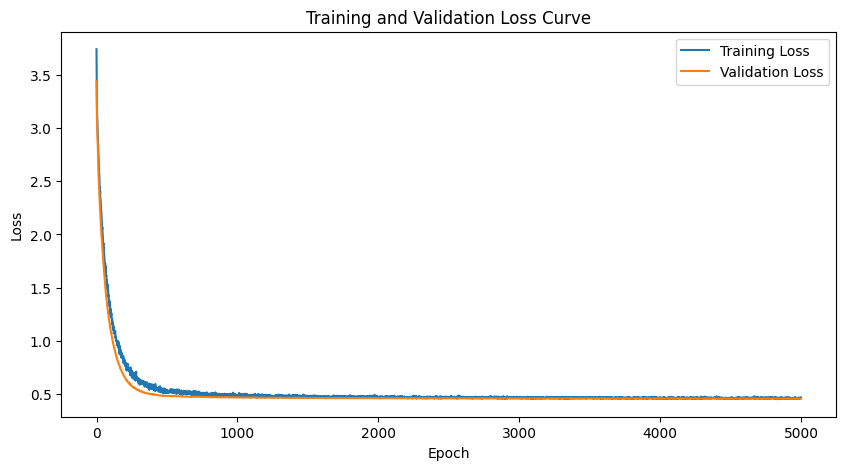

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(losses, label="Training Loss")
ax.plot(val_losses, label="Validation Loss")
ax.set_title("Training and Validation Loss Curve")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

and zooming in we can

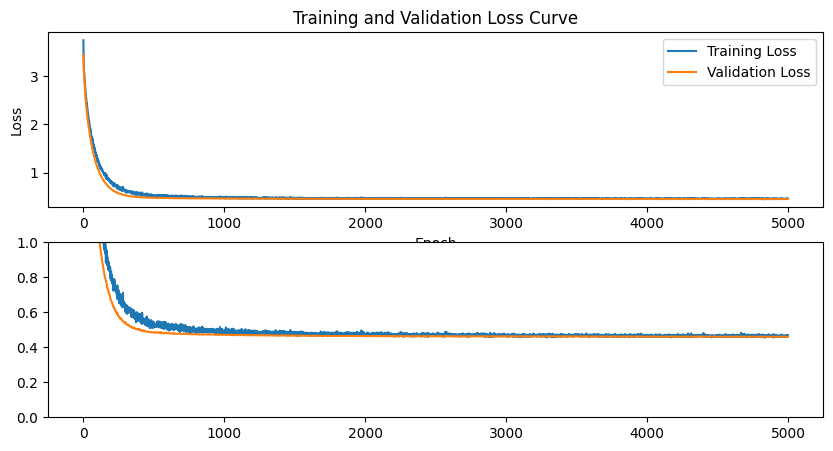

In [59]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

for i in range(2):
    axes[i].plot(losses, label="Training Loss")
    axes[i].plot(val_losses, label="Validation Loss")

    if i == 0:
        axes[i].set_title("Training and Validation Loss Curve")
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel("Loss")
        axes[i].legend()

    if i == 1:
        axes[i].set_ylim(0, 1)

plt.show()

## Final Sampling
With our trained model we can now sample the completion.
For the first one we start with a mostly complete sentence and see if the model can complete the word donuts, which it does.

In [60]:
prompt = "ravin likes don"
final_output = model.sample(tokenizer, prompt, max_completion_len=20, device=device, temperature=1)
final_output.text

'ravin likes donutsE'

We can then try a completion for Ravin and same without suggesting the actual food.
As expected Ravin likes unhealthy food, and Sam by comparisos is prefers healthier salads.x

In [73]:
prompt = "ravin likes "
final_output = model.sample(tokenizer, prompt, max_completion_len=20, device=device, temperature=1)
final_output.text

'ravin likes sodaE'

In [16]:
# ax = sns.heatmap(final_output.completion_logits.cpu().T)

In [47]:
prompt = "sam likes "
sam_output = model.sample(tokenizer, prompt, device=device)
sam_output.text

'sam likes saladE'

We can also see the probability of next token predictions at any state.

In [74]:
temperature = 1
prompt = "ravin likes "

final_output = model.sample(tokenizer, prompt, max_completion_len=20, device=device, temperature=temperature)
print(final_output.text)

predictions = top_k_predictions(model, tokenizer, prompt, device, k=20, temperature=temperature)

for pred in predictions:
    print(f"Token: '{pred['token']}', Probability: {pred['probability']:.2%}")

ravin likes saladE
Token: 's', Probability: 22.33%
Token: 'p', Probability: 13.06%
Token: 'a', Probability: 12.47%
Token: 'l', Probability: 12.23%
Token: 'd', Probability: 11.86%
Token: 'c', Probability: 11.56%
Token: 'i', Probability: 11.47%
Token: 'w', Probability: 0.40%
Token: 'o', Probability: 0.30%
Token: 'v', Probability: 0.28%
Token: 'f', Probability: 0.26%
Token: 'q', Probability: 0.26%
Token: 'x', Probability: 0.26%
Token: 'j', Probability: 0.26%
Token: 'b', Probability: 0.26%
Token: 'y', Probability: 0.26%
Token: 'S', Probability: 0.26%
Token: 'g', Probability: 0.26%
Token: 'P', Probability: 0.26%
Token: 'E', Probability: 0.25%


In [75]:
model.config

{'vocab_size': 30,
 'd_model': 16,
 'nhead': 4,
 'num_decoder_layers': 6,
 'dim_feedforward': 256,
 'dropout': 0.1,
 'context_length': 20,
 'pad_id': 0}

In [76]:
model = pretrain.load_checkpoint("temp/single_stage/model_epoch_799.pt", device="mps")
model = pretrain.load_checkpoint("temp/single_stage/model_epoch_2999.pt", device="mps")

top_k_predictions(model, tokenizer, prompt, device, k=20, temperature=temperature)

[{'token': 's', 'probability': 0.2506028413772583},
 {'token': 'a', 'probability': 0.1256905496120453},
 {'token': 'd', 'probability': 0.12119297683238983},
 {'token': 'p', 'probability': 0.1183789074420929},
 {'token': 'l', 'probability': 0.115565724670887},
 {'token': 'i', 'probability': 0.11067729443311691},
 {'token': 'c', 'probability': 0.10604850947856903},
 {'token': 'o', 'probability': 0.003219934180378914},
 {'token': 'P', 'probability': 0.0029442324303090572},
 {'token': 'f', 'probability': 0.002925768494606018},
 {'token': 'b', 'probability': 0.0028436724096536636},
 {'token': 'x', 'probability': 0.0028291719499975443},
 {'token': 'h', 'probability': 0.0028145054820924997},
 {'token': 'q', 'probability': 0.002813968574628234},
 {'token': 'j', 'probability': 0.0027495003305375576},
 {'token': 'm', 'probability': 0.0027393661439418793},
 {'token': 'S', 'probability': 0.002725489903241396},
 {'token': 'y', 'probability': 0.0027121908497065306},
 {'token': 'g', 'probability': 0.

And lastly we can get sample many times and see the generations.
Our model is not perfect, 
but for our learning purposes this is exactly what we want.
In future steps well see how RL changes this models behavior,
both for the better when implemented well,
and how it hurts performance when implemented poorly.

In [77]:
for _ in range(40):
    final_output = model.sample(tokenizer, prompt, max_completion_len=20, device=device, temperature=temperature)
    print(final_output.text)

ravin likes pSvettuceE
ravin likes sodaE
ravin likes pizzaE
ravin likes applesE
ravin likes ice creamE
ravin likes ttuceE
ravin likes donutsE
ravin likes sodaE
ravin likes pizzadonhesE
ravin likes pizzPE
ravin likes lettuceE
ravin likes ice creamE
ravin likes applesE
ravin likes sodaE
ravin likes pizzaE
ravin likes applesE
ravin likes saladE
ravin likes ice crokiesE
ravin likes sodaE
ravin likes apmE
ravin likes pizzajfE
ravin likes lettuceE
ravin likes ice creamdonutsE
ravin likes ice creamE
ravin likes ice creamE
ravin likes dokicresE
ravin likes lettuceE
ravin likes saladE
ravin likes cookiesE
ravin likes sodaE
ravin likes iSttuceE
ravin likes ice crdonutsE
ravin likes pizzaE
ravin likes lettuceE
ravin likes cookiesE
ravin likes applesE
ravin likes cookiesE
ravin likes donutsE
ravin likes ice cotsE
ravin likes pizzaE


## References
* See pretraining guide in guidebook

## Suggested Prompts
* How does the LLM trained here differ from large scale models? How is it similar?
* How will the design choices with this LLM make RL and post training simpler?